# Python Replication Code for "Capital Allocation and Productivity in South Europe" (Gopinath et al., 2017 QJE)
### by Pedro Armada (https://www.pedroarmada.com)


This program reproduces the quantitative model from the paper
"[Capital Allocation and Productivity in South Europe](https://academic.oup.com/qje/article/132/4/1915/3871448)" which studies how capital misallocation impacts aggregate productivity.

The code uses several techniques to speed up computation:

*   Hardware acceleration (JAX for GPU/TPU)
*   Parallel processing and JIT compilation (Numba)
*   Vectorization/broadcasting to minimize loops (NumPy)

**Acknowledgements**: Credit is given to [QuantEcon](https://quantecon.org/) for the foundational code that served as a starting point for this implementation.

**Stable Link**: https://github.com/PedroArmada/replications/blob/main/gopinath/gopinath_public.ipynb

#### Firm's Problem

Let $\mathbf{X} = (a, k)$ denote the vector of **endogenous state variables**, $\mathbf{Z} = (z^T, z^P)$ denote the vector of **exogenous idiosyncratic states**, and $\mathbf{\Omega} = (z^A, w, r)$ the vector of **exogenous aggregate states**


$$V(\mathbf{X},\mathbf{Z};\mathbf{\Omega}) = \max_{ c,a',k',l  } u(c)+ \beta \mathbb{E} V(\mathbf{X}',\mathbf{Z}';\mathbf{\Omega}')$$

$$c + a' + \phi(k,k') = p(y) y - w l - (r + \delta) k + (1+r)a$$

$$y = z k^\alpha l^{1-\alpha}$$

$$y = p^{-\theta}$$

$$k' \leq \lambda(k',a')$$

##### Productivity

$$z = z^A z^P \exp(z^T) $$

$$z^{T\prime} = - \frac{\sigma^2}{2(1+\rho)} + \rho z^T + \sigma u^{z\prime} \quad \text{with } u^z \sim N(0,1)$$

$$z^P =
\left\{
\begin{array}{ll}
      z_L & \text{with prob } \pi \\
      z_H & \text{with prob } 1-\pi \\
\end{array}
\right.$$

##### Borrowing Constraints

$$k' \leq \lambda_0 a' + \lambda_1 \Psi (k')$$

$$\Psi (k) = \exp(k) - 1$$

##### Capital Adjustment Costs

$$\phi(k,k') = \frac{\psi (k' - k)}{2k} $$

In [1]:
# Install and import required libraries
!pip install --upgrade quantecon

# Importing essential libraries
import matplotlib.pyplot as plt  # For visualization
import numpy as np  # Numerical computations
from numba import jit, njit, prange  # Numba for Just-In-Time compilation and parallelism
from quantecon import MarkovChain  # For handling Markov Chains
from quantecon.markov.approximation import tauchen  # Tauchen method to discretize AR(1) processes
import jax  # JAX for GPU/TPU-accelerated computations
import jax.numpy as jnp  # JAX's version of NumPy

# GPU setup
!nvidia-smi  # Display GPU information
jax.config.update("jax_enable_x64", True)  # Enable 64-bit precision in JAX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 2.8 MB/s eta 0:00:00
Sun Dec  8 19:09:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |            

In [2]:
# Model Definition
def Model(β    = 0.865,
          γ    = 2.000,
          δ    = 0.060,
          θ    = 3.000,
          α    = 0.350,
          ρ    = 0.590,
          σ    = 0.130,
          π    = 0.800,
          zl   = 0.785,
          zh   = 1.860,
          ψ    = 3.200,
          λ0   = 0.980,
          λ1   = 0.047,
          za   = 1.000,
          w    = 1.000,
          r    = 0.100,
          ):

    """
    Defines the economic model parameters and creates the state space.
    """

    # Discretize the AR(1) process for idiosyncratic shocks using Tauchen's method
    mc = tauchen(n=11, rho=ρ, sigma=σ, mu=-(σ**2)/(2*(1+ρ)), n_std=3)
    ztg, ztp = mc.state_values, mc.P

    # Augment the Markov transition probabilities and state grid
    zp = jnp.kron(np.eye(2), ztp)  # Kronecker product for high/low productivity
    zg = jnp.concatenate((za*zl*jnp.exp(ztg), za*zh*jnp.exp(ztg)))  # Productivity levels

    # Define grids for endogenous state variables
    ag = jnp.linspace(start=0.01, stop=3.00, num=120)  # Asset grid
    kg = jnp.linspace(start=0.01, stop=6.00, num=120)  # Capital grid

    # Create the cartesian product of the state variables
    xga, xgk = jnp.meshgrid(ag, kg, indexing='ij')
    xg = jnp.vstack([xga.ravel(), xgk.ravel()]).T

    # Apply borrowing constraints
    xd_f = xg[:, 1] <= λ0 * xg[:, 0] + λ1 * (jnp.exp(xg[:, 1]) - 1)
    xi_f = jnp.arange(xg.shape[0])[xd_f]
    xg_f = xg[xi_f, :]
    xn_f = xg_f.shape[0]

    # Return constants, grid sizes, and arrays
    constants = (β, γ, δ, θ, α, ρ, σ, π, zl, zh, ψ, λ0, λ1, za, w, r)
    sizes = (xn_f, zg.shape[0])
    arrays = (xg_f[:, 0], xg_f[:, 1], zg, zp)

    # Transfer arrays to GPU
    arrays = tuple(map(jax.device_put, arrays))
    return constants, sizes, arrays

In [3]:
# Bellman Operator
def B(v, constants, sizes, arrays):
    """
    Computes the Bellman operator.
    """

    # Unpack constants and arrays
    β, γ, δ, θ, α, ρ, σ, π, zl, zh, ψ, λ0, λ1, za, w, r = constants
    xn, zn = sizes
    ag, kg, zg, zp = arrays

    # Reshape state variables and controls
    a  = jnp.reshape(ag, (xn, 1, 1))    # y[i]   ->  y[i, j, ip]
    k  = jnp.reshape(kg, (xn, 1, 1))    # y[i]   ->  y[i, j, ip]
    z  = jnp.reshape(zg, (1, zn, 1))    # z[j]   ->  z[i, j, ip]
    ap = jnp.reshape(ag, (1, 1, xn))    # yp[ip] -> yp[i, j, ip]
    kp = jnp.reshape(kg, (1, 1, xn))    # yp[ip] -> yp[i, j, ip]

    # Calculate profits, consumption, and utility
    μ = θ / (θ - 1) # Markup
    l = (z * (k ** α) )**((θ - 1)/(1 + α*(θ-1))) * ((μ * w) / (1-α))**(-θ / (1 + α*(θ-1))) # Optimal labor
    y = z * (k ** α) * (l ** (1-α)) # Output
    pi = y ** ((θ-1)/θ) - w * l - (r+δ) * k + (1+r) * a # Profit
    adj = ψ * ( (kp - k) ** 2 ) / ( 2 * k ) # Capital adjustment costs
    c = pi - adj - ap # Consumption
    u = (c ** (1-γ) - 1) / (1-γ) # Utility
    u = jnp.where(c < 0, -1e9, u) # Penalize negative consumption

    # Expected value
    v = jnp.reshape(v, (1, 1, xn, zn))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = jnp.reshape(zp, (1, zn, 1, zn))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = jnp.sum(v * Q, axis=3)                 # sum over last index jp

    return u + β * EV

# JIT compile the Bellman operator for speed
B = jax.jit(B, static_argnums=(2,))

def compute_r_σ(σp, constants, sizes, arrays):
    """
    Computes the immediate reward under a given policy σp.
    """

    # Unpack constants and arrays
    β, γ, δ, θ, α, ρ, σ, π, zl, zh, ψ, λ0, λ1, za, w, r = constants
    xn, zn = sizes
    ag, kg, zg, zp = arrays

    # Reshape state variables for computation
    a = jnp.reshape(ag, (xn, 1))  # Asset grid
    k = jnp.reshape(kg, (xn, 1))  # Capital grid
    z = jnp.reshape(zg, (1, zn))  # Productivity grid

    # Use policy σp to determine next-period assets and capital
    ap = ag[σp]  # Policy for next-period assets
    kp = kg[σp]  # Policy for next-period capital

    # Calculate profits, consumption, and utility
    μ = θ / (θ - 1)
    l = (z * (k ** α) )**((θ - 1)/(1 + α*(θ-1))) * ((μ * w) / (1-α))**(-θ / (1 + α*(θ-1)))
    y = z * (k ** α) * (l ** (1-α))
    pi = y ** ((θ-1)/θ) - w * l - (r+δ) * k + (1+r) * a
    adj = ψ * ( (kp - k) ** 2 ) / ( 2 * k )
    c = pi - adj - ap

    # Compute utility with a penalty for infeasible consumption
    u = (c ** (1-γ) - 1) / (1-γ)
    r_σ = jnp.where(c < 0, -1e9, u)
    return r_σ

# JIT compile the current reward function
compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))

def L_σ(v, σp, constants, sizes, arrays):
    """
    Computes the LHS operator of the Bellman equation under a given policy σp.
    This is used for solving the Bellman equation iteratively or via linear algebra methods.
    """

    # Unpack constants and arrays
    β, γ, δ, θ, α, ρ, σ, π, zl, zh, ψ, λ0, λ1, za, w, r = constants
    xn, zn = sizes
    ag, kg, zg, zp = arrays

    # Prepare indices for the Markov transition probabilities
    zp_idx = jnp.arange(zn)
    zp_idx = jnp.reshape(zp_idx, (1, 1, zn))

    # Reshape policy and transition matrix and extract future value function under given policy
    σp = jnp.reshape(σp, (xn, zn, 1))
    V = v[σp, zp_idx]
    Q = jnp.reshape(zp, (1, zn, zn))

    # Compute the LHS of the Bellman equation
    return v - β * jnp.sum(V * Q, axis=2)

# JIT compile the LHS operator
L_σ = jax.jit(L_σ, static_argnums=(3,))

In [4]:
def get_greedy(v, constants, sizes, arrays):
    """
    Computes the greedy policy function.
    """
    return jnp.argmax(B(v, constants, sizes, arrays), axis=2)

# JIT compile the greedy policy function
get_greedy = jax.jit(get_greedy, static_argnums=(2,))

def get_value(σp, constants, sizes, arrays):
    """
    Computes the value function under a given policy using iterative solver.
    """

    # Unpack constants and arrays
    β, γ, δ, θ, α, ρ, σ, π, zl, zh, ψ, λ0, λ1, za, w, r = constants
    xn, zn = sizes
    ag, kg, zg, zp = arrays

    # Compute RHS of the Bellman equation under the policy
    r_σ = compute_r_σ(σp, constants, sizes, arrays)
    partial_L_σ = lambda v: L_σ(v, σp, constants, sizes, arrays)

    # Solve the Bellman equation using an iterative sparse solver (BiCGSTAB)
    return jax.scipy.sparse.linalg.bicgstab(partial_L_σ, r_σ)[0]

# JIT compile
get_value = jax.jit(get_value, static_argnums=(2,))

def policy_iteration(model, maxiter=250):
    """
    Performs policy iteration to find the optimal policy function.
    """

    # Unpack the model
    constants, sizes, arrays = model

    # Initialize the policy function with zeros
    σp = jnp.zeros(sizes, dtype=int)

    # Initialize the iteration counter and error tolerance
    i, error = 0, 1.0

    while error > 0 and i < maxiter:

        # Compute the value function under the current policy
        v_σ = get_value(σp, constants, sizes, arrays)

        # Find the new policy by applying the greedy operator to the value function
        σp_new = get_greedy(v_σ, constants, sizes, arrays)

        # Check for convergence
        error = jnp.max(jnp.abs(σp_new - σp))

        # Update the policy function
        σp = σp_new

        # Increment the iteration counter
        i = i + 1

    # Return the optimal policy function
    return σp

In [5]:
################# SIMULATIONS

@njit(parallel=True)
def simul_x(pol_x, hist_x, hist_z, N, T):
    """
    Simulates the evolution of states over time given a policy.

    Parameters:
    - pol_x: Policy function specifying the action to take for each state.
    - hist_x: Array to store the history of states for each simulation.
    - hist_z: Array of exogenous shocks for each simulation.
    - N: Number of firms.
    - T: Number of time periods to simulate.

    Returns:
    - hist_x: Updated array containing the simulated state history for all agents.

    Notes:
    - The `@njit` decorator compiles the function to machine code using Numba.
    - `parallel=True` allows Numba to parallelize the outer loop (over `N` firms).
    """
    for i in prange(N): # Parallel loop over agents
        for t in range(T-1): # Loop over time periods
            hist_x[i,t+1] = pol_x[hist_x[i,t],hist_z[i,t]] # Update the state at the next time step based on the policy and current state
    return hist_x


def simul(pol_x, N, T, constants, sizes, arrays, dist_x, verbose = True):
    """
    Simulates the evolution of states and shocks over time for multiple agents.
    """

    # Unpack constants and arrays
    β, γ, δ, θ, α, ρ, σ, π, zl, zh, ψ, λ0, λ1, za, w, r = constants
    xn, zn = sizes
    ag, kg, zg, zp = arrays

    # Initialize the history of states and set the initial state distribution
    hist_x = np.zeros((N,T)).astype(int)
    hist_x[:,0] = dist_x

    # Set a random seed for reproducibility
    np.random.seed(1234)

    # Transition probabilities for productivity shocks
    mc = MarkovChain(zp)

    # Create initial shocks based on the steady-state probabilities
    init_z = np.concatenate( (  np.full( int(N*π) , int(0.25*zn) ), np.full( N - int(N*π) , int(0.75*zn)) )  )

    # Simulate the exogenous shock history for all agents
    hist_z = mc.simulate_indices(ts_length = T, init = init_z)

    # Simulate the state transitions based on the policy function and shocks
    hist_x = simul_x(pol_x,hist_x,hist_z,N,T)

    if verbose:
        print('Simulations complete!')

    # Return the history of states and shocks
    return hist_x, hist_z

----------- r iteration: 1 of 6
----------- r iteration: 2 of 6
----------- r iteration: 3 of 6
----------- r iteration: 4 of 6
----------- r iteration: 5 of 6
----------- r iteration: 6 of 6


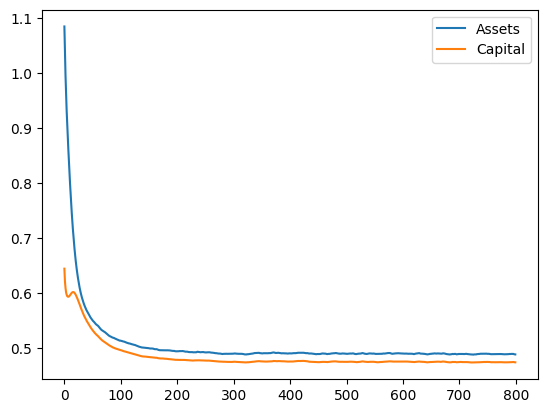

In [6]:
# Initialize the model
model = Model()
constants, sizes, arrays = model
ag, kg, zg, zp = arrays
xn, zn = sizes

# Define an array of values for the interest rate
rg = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.10])
rn = len(rg) # Number of interest rate values

# Initialize arrays to store policies for different interest rates
pol_x_r, pol_a_r, pol_k_r = np.zeros((xn,zn,rn)), np.zeros((xn,zn,rn)), np.zeros((xn,zn,rn))

# Loop over interest rates and compute policies
for ri in range(rn):
    print("----------- r iteration:", ri + 1 ,"of", rn)

    # Update the model with the current interest rate
    model = Model(r = rg[ri])

    # Compute the optimal policy using policy iteration
    pol_x = policy_iteration(model, maxiter=15)

    # Map the policy indices to asset and capital grids
    pol_a, pol_k = ag[pol_x], kg[pol_x]

    # Store the computed policies for the current interest rate
    pol_x_r[:,:,ri], pol_a_r[:,:,ri], pol_k_r[:,:,ri] = pol_x, pol_a, pol_k

# Set the initial interest rate to obtain the stationary distribution
model = Model(r = rg[-1])
constants, sizes, arrays = model

# Simulation parameters
N  = 50000 # Number of firms
T  = 1000  # Total time periods for simulation
Ts = 800   # Subset of time periods to analyze

# Simulate the evolution of states and shocks
hist_x, hist_z = simul(pol_x_r[:,:,-1], N, Ts, constants, sizes, arrays, dist_x=np.ones(N)*2000, verbose=False)

# Map the simulated states to asset and capital values
hist_a = pol_a[hist_x,hist_z] # Simulated asset history
hist_k = pol_k[hist_x,hist_z] # Simulated capital history

# Compute the mean evolution of assets and capital over time
evol_a = np.mean(hist_a, axis=0)
evol_k = np.mean(hist_k, axis=0)

# Plot the evolution of aggregate assets and capital to check for convergence
plt.plot(evol_a, label='Assets')   # Plot evolution of assets
plt.plot(evol_k, label='Capital')  # Plot evolution of capital
plt.legend()
plt.show()

In [7]:
# Define the path of interest rates over time
r_path = np.array([6,6,5,5,5,4,3,1,2,2,1,1,1,1,2,3,2,3,2,2,2,2,2,2,2,2])-1

# Initialize distributions for states and shocks
dist_x = hist_x[:,-1]
hist_x_t, hist_z_t = np.zeros((N,len(r_path))).astype(int), np.zeros((N,len(r_path))).astype(int)

# Iterate over the interest rate path
for ri in range(len(r_path)):

    # Update the model with the current interest rate from the path
    model = Model(r = rg[r_path[ri]])
    constants, sizes, arrays = model

    # Retrieve the policy function for the current interest rate
    pol_x = pol_x_r[:,:,r_path[ri]]

    # Simulate using the current policy and distribution
    hist_x_temp, hist_z_temp = simul(pol_x,N,2,constants, sizes, arrays,dist_x=dist_x,verbose=False)

    # Store the simulation
    hist_x_t[:,ri], hist_z_t[:,ri] = hist_x_temp[:,-1], hist_z_temp[:,-1]

    # Update the distribution for the next period
    dist_x = hist_x_t[:,ri]

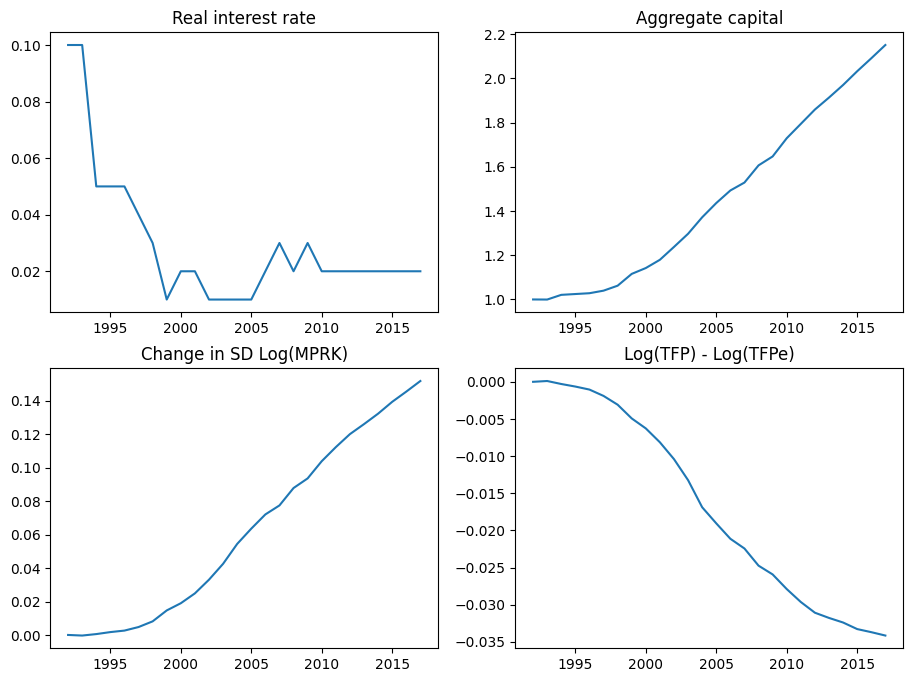

In [8]:
# Unpack constants
β, γ, δ, θ, α, ρ, σ, π, zl, zh, ψ, λ0, λ1, za, w, r = constants

# Map histories of interest rates, assets, and capital
hist_r_t = np.tile(r_path[:,np.newaxis].T,(N,1))
hist_a_t = pol_a_r[hist_x_t,hist_z_t,hist_r_t]
hist_k_t = pol_k_r[hist_x_t,hist_z_t,hist_r_t]

# Calculate individual histories
μ = θ / (θ - 1)
hist_l_t = (zg[hist_z_t] * (hist_k_t ** α) )**((θ - 1)/(1 + α*(θ-1))) * ((μ * w) / (1-α))**(-θ / (1 + α*(θ-1)))
hist_y_t = zg[hist_z_t] * (hist_k_t ** α) * (hist_l_t ** (1-α))
hist_p_t = hist_y_t ** (-1/θ)
hist_mrpl_t = ( (1-α) / μ) * ( hist_y_t ** ((θ-1)/θ) ) / hist_l_t
hist_mrpk_t = ( α / μ) * ( hist_y_t ** ((θ-1)/θ) ) / hist_k_t
hist_tfpr_t = μ * (( hist_mrpk_t / α ) ** α ) * (( hist_mrpl_t / (1-α) ) ** (1-α) )

# Calculate evolution of aggregates
evol_a_t = np.mean(hist_a_t, axis=0)
evol_k_t = np.mean(hist_k_t, axis=0)
evol_sdmrpl_t = np.std( np.log(hist_mrpl_t) , axis=0)
evol_sdmrpk_t = np.std( np.log(hist_mrpk_t) , axis=0)
evol_tfpr_t = np.mean(np.log(hist_tfpr_t), axis=0)
evol_logtfpa_t = np.log( ( np.sum( hist_y_t ** ((θ-1)/θ) , axis=0) ** (θ/(θ-1)) ) / ( ( np.sum( hist_k_t , axis=0) ** α ) * ( np.sum( hist_l_t , axis=0) ** (1-α) ) ) )
evol_logtfpe_t = np.log( np.sum( zg[hist_z_t] ** (θ-1) , axis=0) ** (1/(θ-1)) )
evol_dev_logtfp_t = evol_logtfpa_t - evol_logtfpe_t

# Reproduce Figure 8 - Evolution of Aggregate Variables in Baseline HeF Model from original paper
years = np.arange(1992,2017+1,dtype=int)

fig, ax = plt.subplots(2,2)
fig.set_size_inches(11, 8)
ax[0,0].plot(years, rg[r_path])
ax[0,0].set_title("Real interest rate")
ax[0,1].plot(years, evol_k_t / evol_k_t[0])
ax[0,1].set_title("Aggregate capital")
ax[1,0].plot(years, evol_sdmrpk_t - evol_sdmrpk_t[0])
ax[1,0].set_title("Change in SD Log(MPRK)")
ax[1,1].plot(years, evol_dev_logtfp_t - evol_dev_logtfp_t[0])
ax[1,1].set_title("Log(TFP) - Log(TFPe)")
plt.show()

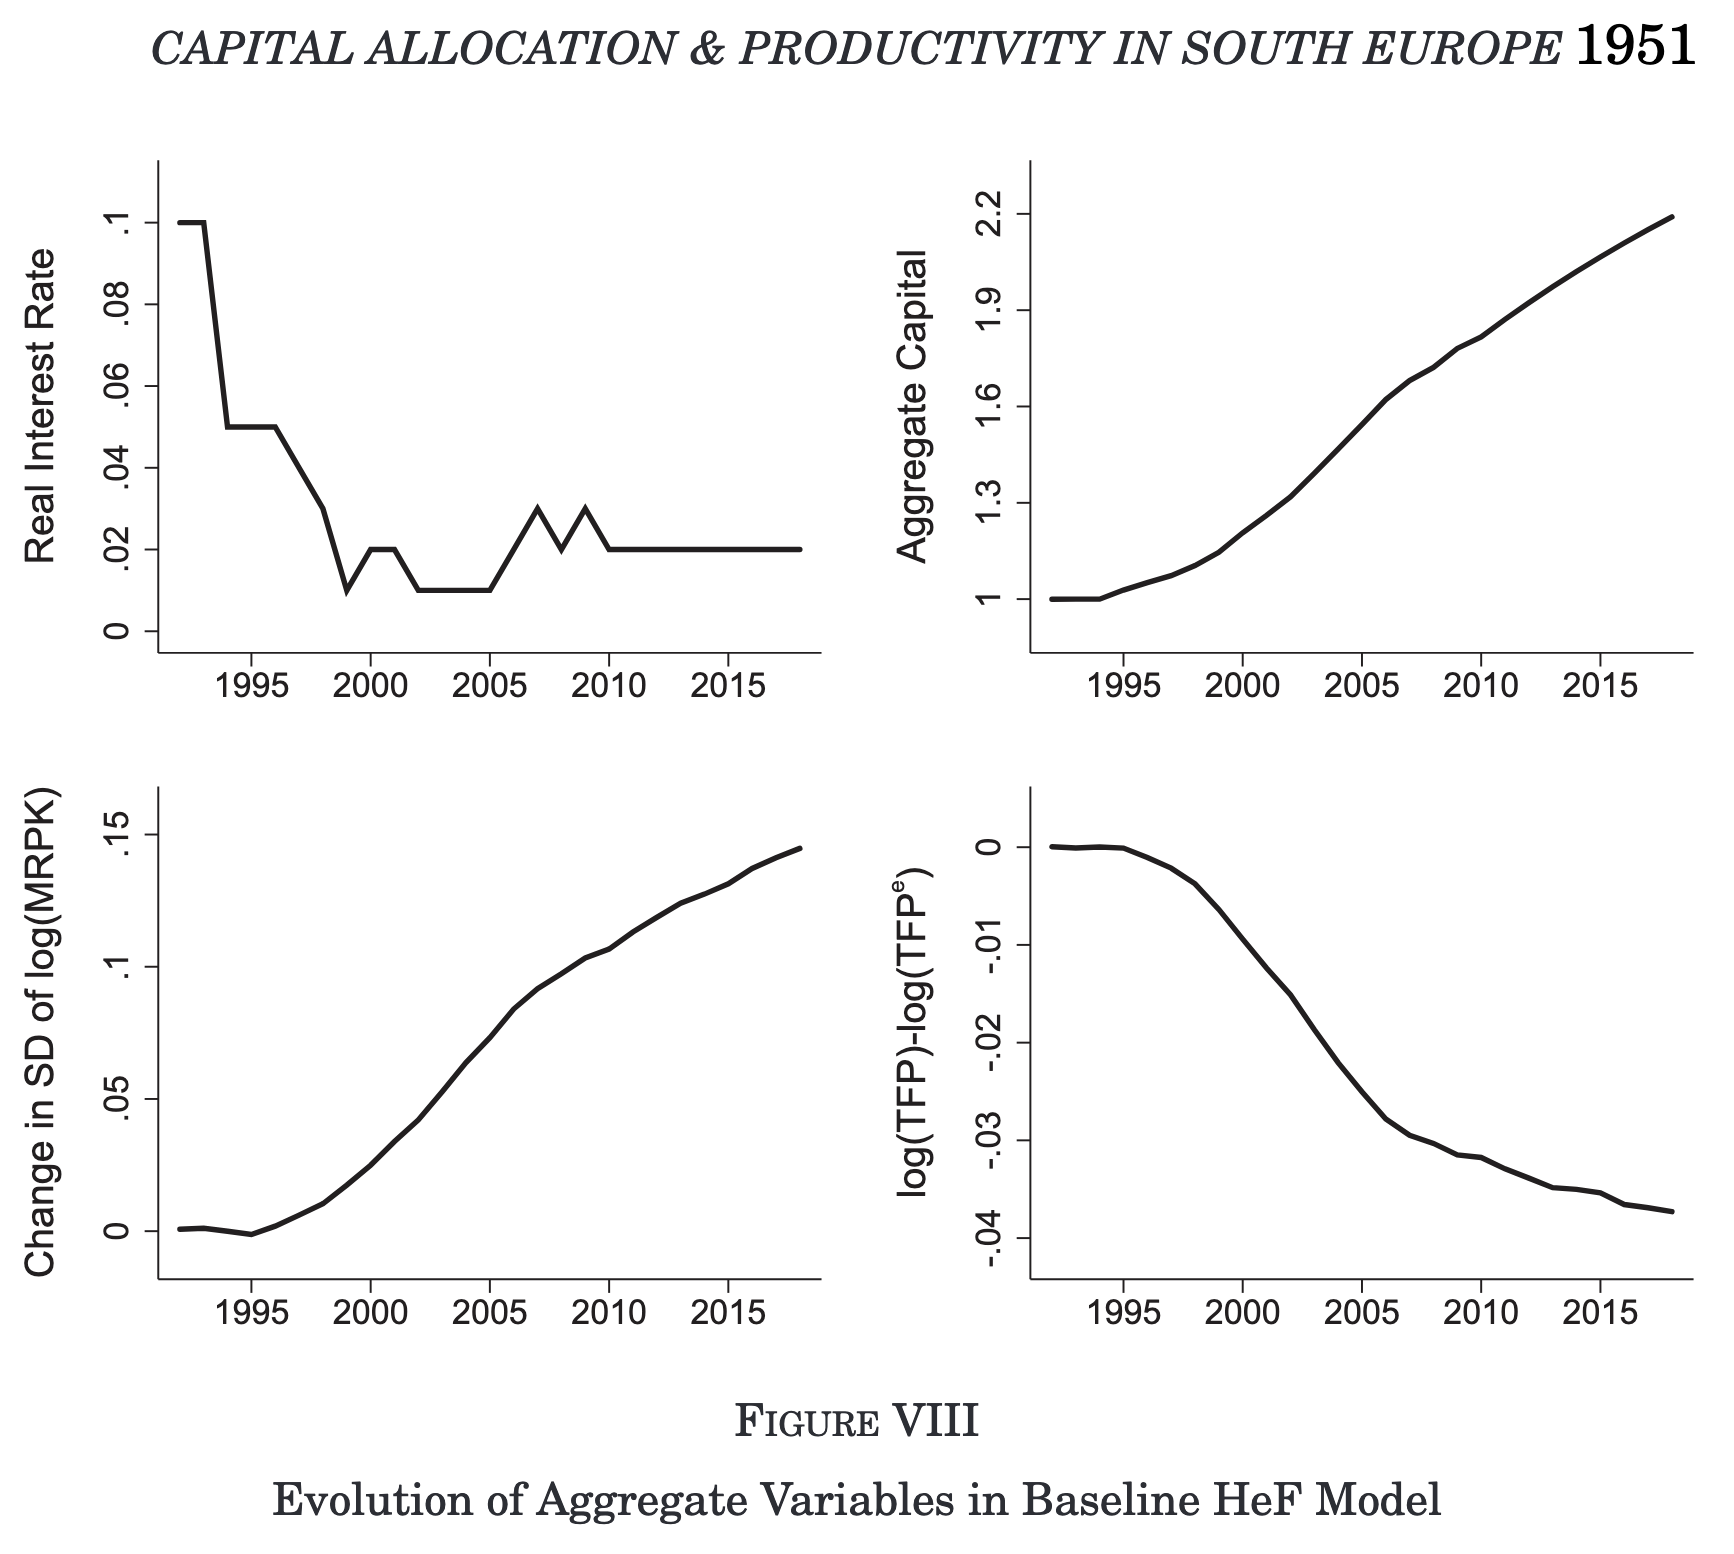